# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [65]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

#### I am used to select 100k data points randaand sord them using time based splitting

In [5]:
# Split the data into train , test and crossvalidation datasets
# load "preprocessed.pkl" data frame
df = pd.read_pickle("files/preprocessed.pkl")
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational


In [6]:
df.shape

(364171, 12)

In [7]:
# take 50k sample data randomly
sample_data = df.sample(100000)
sample_data.shape

(100000, 12)

In [8]:
# sorted the data using time based
sorted_data = sample_data.sort_values('Time', axis=0, inplace=False)
sorted_data.shape

(100000, 12)

In [9]:
sorted_data['Score'].value_counts()

1    84283
0    15717
Name: Score, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = np.array(sorted_data['CleanedText'])
y = np.array(sorted_data['Score'])
print(X.shape)
print(y.shape)

(100000,)
(100000,)


In [12]:
# Simple cross validation
# split the data sent into train and test
train , test , train_y , test_y = train_test_split(X, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train, cv , train_y, cv_y = train_test_split(train, train_y, test_size=0.3, random_state=None)

print("train data = ", train.shape)
print("cros validation = ", cv.shape)
print("test data = ", test.shape)

train data =  (49000,)
cros validation =  (21000,)
test data =  (30000,)


## [4.1] BAG OF WORDS

In [15]:
#BoW
count_vect = CountVectorizer(min_df=10 ,) #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.fit_transform(train)
final_counts_cv = count_vect.transform(cv)
final_counts_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(final_counts_cv))
print("the shape of out text BOW vectorizer ",final_counts_cv.get_shape())
print("the number of unique words ", final_counts_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 18540)
the number of unique words  18540
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 18540)
the number of unique words  18540
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 18540)
the number of unique words  18540


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [2]:
# after preprocessing 
df = pd.read_pickle("files/preprocessed.pkl")
df.shape

(364171, 12)

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


In [4]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , f1_score , confusion_matrix
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score , roc_curve
from sklearn.model_selection import train_test_split

/home/prasad/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/prasad/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [99]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=5, ngram_range=(1,2)) #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.fit_transform(train)
bow_cv = count_vect.transform(cv)
bow_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv))
print("the shape of out text BOW vectorizer ",bow_cv.get_shape())
print("the number of unique words ", bow_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test))
print("the shape of out text BOW vectorizer ",bow_test.get_shape())
print("the number of unique words ", bow_test.get_shape()[1])

some feature names  ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'ability make', 'able', 'able actually', 'able afford']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 64147)
the number of unique words  64147
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 64147)
the number of unique words  64147
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 64147)
the number of unique words  64147


In [100]:
C = [pow(10,j) for j in range(-4,4,1)]

In [101]:
bow_train_auc = []
bow_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i)
    LR.fit(bow_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(bow_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(bow_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 73.77%

CV AUC for λ = 0.0001 is 73.53%

Train AUC for λ = 0.001 is 91.16%

CV AUC for λ = 0.001 is 90.16%

Train AUC for λ = 0.01 is 96.22%

CV AUC for λ = 0.01 is 94.05%

Train AUC for λ = 0.1 is 99.26%

CV AUC for λ = 0.1 is 95.29%

Train AUC for λ = 1 is 99.98%

CV AUC for λ = 1 is 95.16%

Train AUC for λ = 10 is 100.00%

CV AUC for λ = 10 is 94.69%

Train AUC for λ = 100 is 100.00%

CV AUC for λ = 100 is 94.18%

Train AUC for λ = 1000 is 100.00%

CV AUC for λ = 1000 is 93.82%


In [102]:
hyper = [str(pow(10,j)) for j in range(-4,4)]

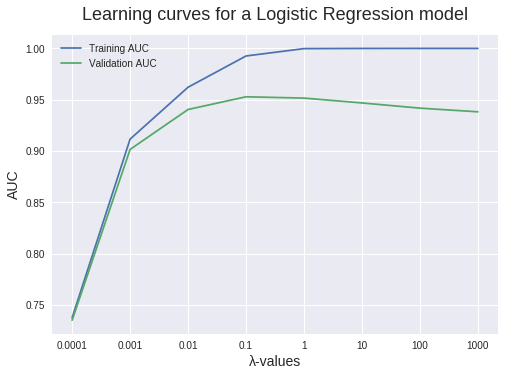

In [103]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [104]:
i = 0.1
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
# train data
y_prob_train = LR.predict_proba(bow_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(bow_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(bow_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.1 is 99.26%

CV AUC for λ = 0.1 is 95.29%

Test AUC for λ = 0.1 is 95.19%


In [110]:
# number of non-zero weights
w = LR.coef_
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of non-zero weights :  64147


***observation :*** The number of non-zero weights are same as the total weights . we can observe that there is no sparsity in this weights

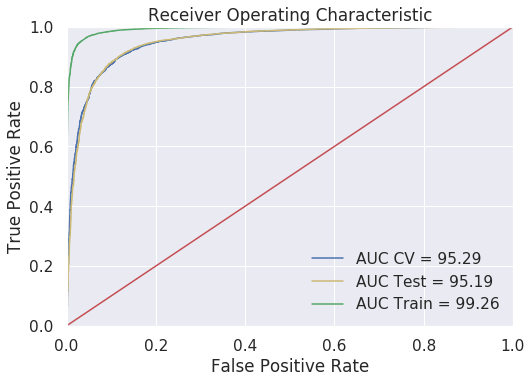

In [111]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [112]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.96


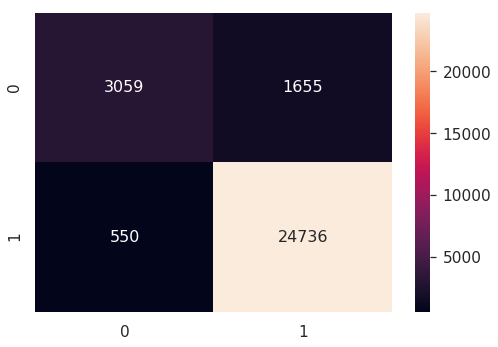

In [113]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [114]:
C = [pow(10,j) for j in range(-4,4,1)]

In [116]:
bow_train_auc = []
bow_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l1")
    LR.fit(bow_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(bow_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(bow_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 50.00%

CV AUC for λ = 0.0001 is 50.00%

Train AUC for λ = 0.001 is 71.71%

CV AUC for λ = 0.001 is 72.23%

Train AUC for λ = 0.01 is 88.30%

CV AUC for λ = 0.01 is 87.87%

Train AUC for λ = 0.1 is 95.33%

CV AUC for λ = 0.1 is 94.02%

Train AUC for λ = 1 is 99.70%

CV AUC for λ = 1 is 94.70%

Train AUC for λ = 10 is 100.00%

CV AUC for λ = 10 is 93.80%

Train AUC for λ = 100 is 100.00%

CV AUC for λ = 100 is 93.47%

Train AUC for λ = 1000 is 100.00%

CV AUC for λ = 1000 is 93.52%


In [46]:
hyper = [str(pow(10,j)) for j in range(-4,4)]

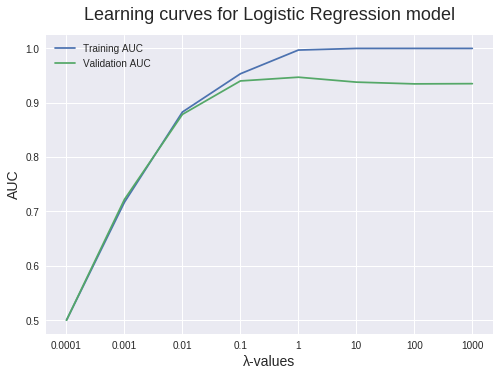

In [117]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [118]:
i = 1
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
# train data
y_prob_train = LR.predict_proba(bow_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(bow_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(bow_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 1 is 99.98%

CV AUC for λ = 1 is 95.16%

Test AUC for λ = 1 is 95.06%


In [122]:
# number of non-zero weights
w = LR.coef_
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of non-zero weights :  64147


In [124]:
w.shape

(1, 64147)

***observation :*** The number of non-zero weights are same as the total weights . we can observe that there is no sparsity in this weights

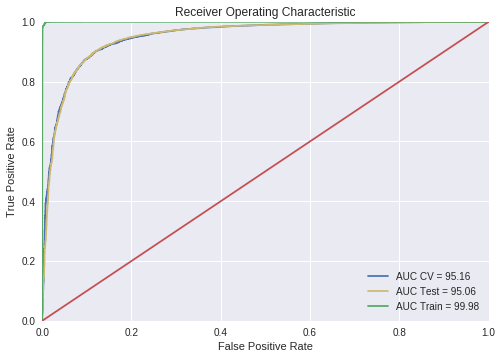

In [119]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [120]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.96


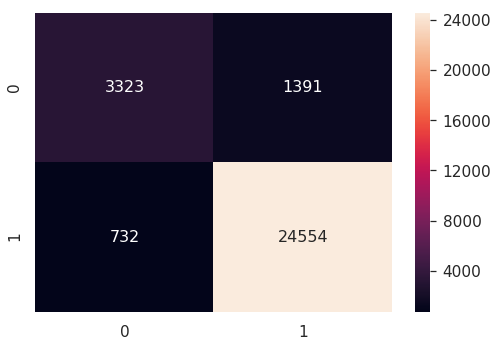

In [121]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [125]:
# Please write all the code with proper documentation
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64147


***observation :*** The number of non-zero weights are same as the total weights . we can observe that there is no sparsity in this weights

In [126]:
# we want to increase Lambda (decreasing C)
i = 0.1
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64147


In [127]:
# we want to increase Lambda (decreasing C)
i = 0.01
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64147


In [128]:
# we want to increase Lambda (decreasing C)
i = 0.001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64147


In [129]:
# we want to increase Lambda (decreasing C)
i = 0.0001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64147


In [130]:
# we want to increase Lambda (decreasing C)
i = 0.00001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64147


In [141]:
# we want to increase Lambda (decreasing C)
i = 0.000000001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64138


***Observation :*** hear it self stating sparcity

In [142]:
# we want to increase Lambda (decreasing C)
i = 0.00000000001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64139


In [143]:
# we want to increase Lambda (decreasing C)
i = 0.0000000000001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  64135


In [148]:
# we want to increase Lambda (decreasing C)
i = 0.000000000000000001
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  64147
Number of non-zero weights :  0


***Observation :*** we Observe More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [282]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=15) #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.fit_transform(train)
bow_cv = count_vect.transform(cv)
bow_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv))
print("the shape of out text BOW vectorizer ",bow_cv.get_shape())
print("the number of unique words ", bow_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test))
print("the shape of out text BOW vectorizer ",bow_test.get_shape())
print("the number of unique words ", bow_test.get_shape()[1])

some feature names  ['ability', 'able', 'absence', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absorbing', 'absorbs']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 7033)
the number of unique words  7033
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 7033)
the number of unique words  7033
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 7033)
the number of unique words  7033


In [439]:
# createing a noise (epsilon)
epsilon = np.random.normal(loc=0.0, scale=0.0001)

In [440]:
from scipy.sparse import csr_matrix

In [441]:
# adding a noise to test data only
bow_train_noise = csr_matrix(bow_train)
bow_train_noise.data = bow_train_noise.data + epsilon

In [442]:
bow_train_noise.shape

(49000, 7033)

In [443]:
# train a Logistic Regression model with noised data
i = 0.1
LR = LogisticRegression(C=i)
LR.fit(bow_train_noise, train_y)
noised_w = LR.coef_

In [560]:
# train a Logistic Regression model with un-noised data data
i = 0.1
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
w = LR.coef_

In [561]:
weights = w

In [468]:
# and adding a small eps value (to eliminate the divisible by zero error)
e = 10**-6
w = w + e
noised_w = noised_w + e

In [469]:
# claculate the % change between w and noised_w
percent_changed = abs((w - noised_w)/w)*100

In [470]:
a = np.sort(percent_changed, axis=None)

In [471]:
max(a)

25.83058033878627

In [472]:
min(a)

5.775007388487825e-07

In [473]:
a.shape

(7033,)

In [474]:
a_percentile = []
for i in range(0,100,1):
    p = np.percentile(a,i)
    a_percentile.append(p)

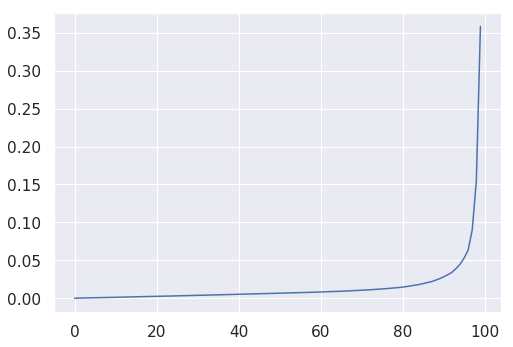

In [475]:
plt.plot(a_percentile)

***Observation :*** from above percentile plot we can observe there is sudden rise between 95th percentile and 100th percentile , now we want to find threshold 

In [482]:
[np.percentile(a,i) for i in range(95,101,1)]

[0.05281317830811581,
 0.06336159816657352,
 0.0903473829166577,
 0.15490152148891556,
 0.35853650608036164,
 25.83058033878627]

***Observation :*** from the above loop we observed sudden rise b/w 99th and 100th percentiles

In [505]:
l = [99, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]
pl = []
for i in l:
    p = np.percentile(a,i)
    pl.append(p)
    print("%0.1f values = %f"%(i,p))

99.0 values = 0.358537
99.1 values = 0.378953
99.2 values = 0.423514
99.3 values = 0.448876
99.4 values = 0.567246
99.5 values = 0.662503
99.6 values = 0.916526
99.7 values = 1.152944
99.8 values = 1.975175
99.9 values = 6.604124
100.0 values = 25.830580


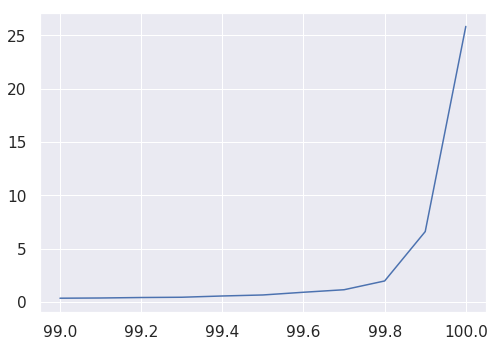

In [506]:
plt.plot(l,pl)

***Observe :*** we observe from the above plot there is a sudden rise from 1.9 to 6.6 . we can select the threshold as 1.9

**Threshold = 1.9**

In [531]:
# now we want to print the feature names whose % change is more than a threshold 1.9
weights = percent_changed.tolist()[0]
feature_names = count_vect.get_feature_names()
features = dict(zip(weights,feature_names))

In [559]:
print("Feature names ==> Weights")
print("="*50)
for key,value in features.items():
    if key > 1.9:
        print('%s ==> %s'%(str(value),str(round(key,3))))

Feature names ==> Weights
causing ==> 9.43
containing ==> 4.927
crave ==> 23.433
crushed ==> 10.516
darjeeling ==> 1.944
draw ==> 3.847
gatorade ==> 3.399
growth ==> 2.69
making ==> 5.594
near ==> 8.749
oats ==> 5.465
painful ==> 1.977
region ==> 7.338
repeatedly ==> 6.638
spend ==> 9.14
spite ==> 1.947
wanting ==> 25.831


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [579]:
# Please write all the code with proper documentation
feture_weights = weights.tolist()[0]
feature_names = count_vect.get_feature_names()
features = dict(zip(feture_weights,feature_names))

In [584]:
features_df = pd.DataFrame.from_dict(features, orient='index')

In [587]:
sorted_features = features_df.sort_index(axis=0,ascending=False )

In [590]:
# top 10 important features of positive class
sorted_features.head(10)

,0
1.471624,delicious
1.373267,excellent
1.265165,perfect
1.211439,highly
1.207375,wonderful
1.206477,great
1.205229,amazing
1.194831,best
1.093144,yummy
1.069295,awesome


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [599]:
# Please write all the code with proper documentation
sorted_features = features_df.sort_index(axis=0,ascending=True )
sorted_features.head(10)

,0
-1.946078,disappointing
-1.669927,worst
-1.538319,disappointment
-1.498460,terrible
-1.394829,awful
-1.381296,disappointed
-1.377574,threw
-1.255345,unfortunately
-1.168864,horrible
-1.161546,stale


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [631]:
# Please write all the code with proper documentation

model = TfidfVectorizer(min_df=20, ngram_range=(1,2))
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(tf_idf_train))
print("the shape of out text TFIDF vectorizer ",tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ",tf_idf_train.get_shape()[1])
print("================CV Data===========")
tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ",tf_idf_cv.get_shape()[1])
print("================Test Data===========")
tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(tf_idf_test))
print("the shape of out text TFIDF vectorizer ",tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49000, 13790)
the number of unique words including both unigrams and bigrams  13790
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (21000, 13790)
the number of unique words including both unigrams and bigrams  13790
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 13790)
the number of unique words including both unigrams and bigrams  13790


In [632]:
C = [pow(10,j) for j in range(-4,4,1)]
tfidf_train_auc = []
tfidf_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l1")
    LR.fit(tf_idf_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(tf_idf_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(tf_idf_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 50.00%

CV AUC for λ = 0.0001 is 50.00%

Train AUC for λ = 0.001 is 50.00%

CV AUC for λ = 0.001 is 50.00%

Train AUC for λ = 0.01 is 68.31%

CV AUC for λ = 0.01 is 68.91%

Train AUC for λ = 0.1 is 90.33%

CV AUC for λ = 0.1 is 89.89%

Train AUC for λ = 1 is 96.76%

CV AUC for λ = 1 is 95.41%

Train AUC for λ = 10 is 99.89%

CV AUC for λ = 10 is 94.70%

Train AUC for λ = 100 is 100.00%

CV AUC for λ = 100 is 93.16%

Train AUC for λ = 1000 is 100.00%

CV AUC for λ = 1000 is 92.64%


In [633]:
hyper = [str(pow(10,j)) for j in range(-4,4)]

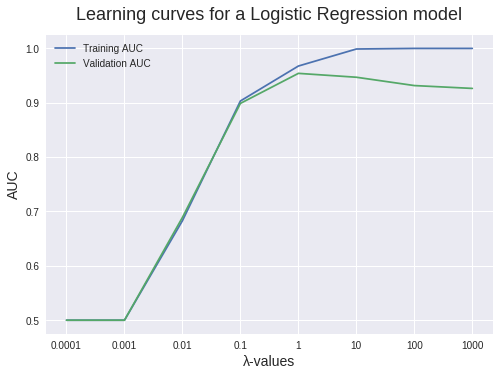

In [634]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [635]:
i = 1
LR = LogisticRegression(C=i , penalty="l1")
LR.fit(tf_idf_train, train_y)
# train data
y_prob_train = LR.predict_proba(tf_idf_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(tf_idf_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(tf_idf_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 1 is 96.76%

CV AUC for λ = 1 is 95.41%

Test AUC for λ = 1 is 95.36%


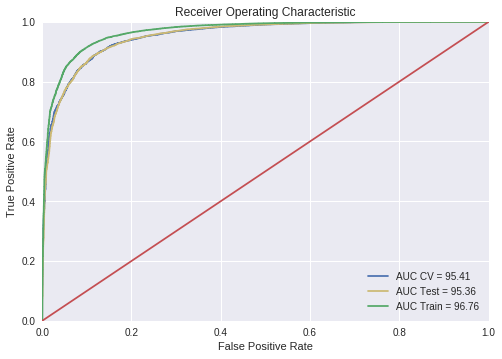

In [636]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [637]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.96


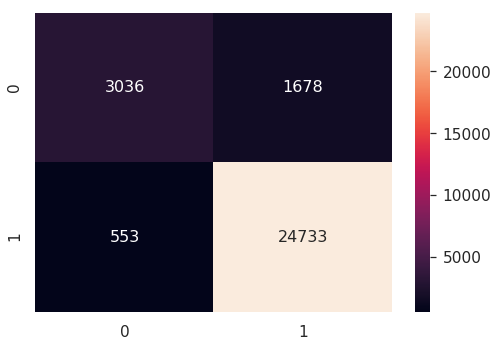

In [638]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [640]:
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  13790
Number of non-zero weights :  1190


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [641]:
# Please write all the code with proper documentation
C = [pow(10,j) for j in range(-4,4,1)]
tfidf_train_auc = []
tfidf_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l2")
    LR.fit(tf_idf_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(tf_idf_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(tf_idf_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 73.06%

CV AUC for λ = 0.0001 is 72.73%

Train AUC for λ = 0.001 is 92.14%

CV AUC for λ = 0.001 is 91.45%

Train AUC for λ = 0.01 is 92.42%

CV AUC for λ = 0.01 is 91.71%

Train AUC for λ = 0.1 is 95.04%

CV AUC for λ = 0.1 is 94.05%

Train AUC for λ = 1 is 97.88%

CV AUC for λ = 1 is 95.95%

Train AUC for λ = 10 is 99.53%

CV AUC for λ = 10 is 95.92%

Train AUC for λ = 100 is 99.97%

CV AUC for λ = 100 is 94.56%

Train AUC for λ = 1000 is 100.00%

CV AUC for λ = 1000 is 93.62%


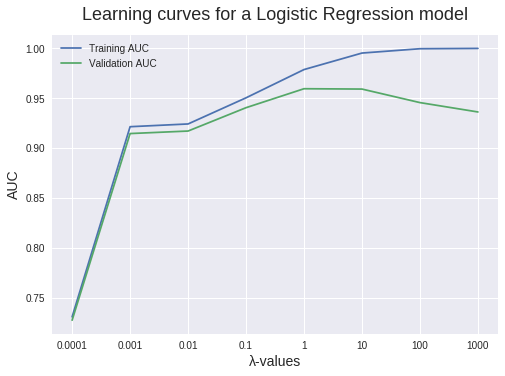

In [642]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [643]:
i = 1
LR = LogisticRegression(C=i , penalty="l2")
LR.fit(tf_idf_train, train_y)
# train data
y_prob_train = LR.predict_proba(tf_idf_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(tf_idf_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(tf_idf_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 1 is 97.88%

CV AUC for λ = 1 is 95.95%

Test AUC for λ = 1 is 95.89%


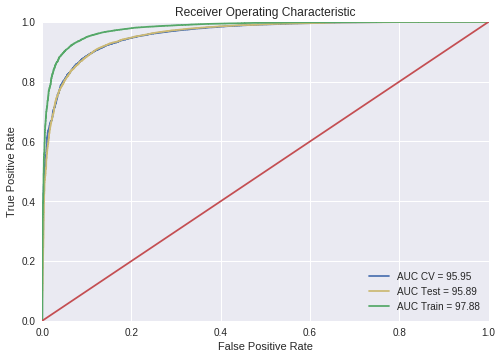

In [644]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [645]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.96


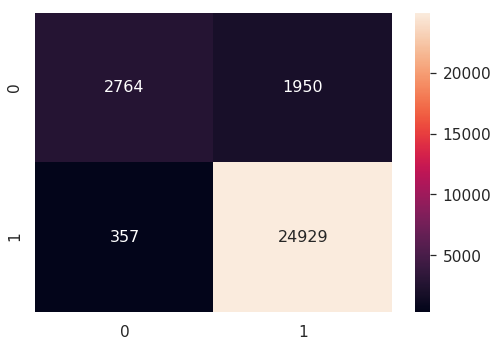

In [646]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [647]:
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  13790
Number of non-zero weights :  13790


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [648]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
feture_weights = w.tolist()[0]
feature_names = model.get_feature_names()
features = dict(zip(feture_weights,feature_names))

In [649]:
features_df = pd.DataFrame.from_dict(features, orient='index')
sorted_features = features_df.sort_index(axis=0,ascending=False )

In [650]:
sorted_features.head(10)

,0
10.468457,great
7.847426,best
7.318638,delicious
6.693858,good
6.271667,love
5.871083,perfect
5.546432,excellent
5.454443,wonderful
4.946091,loves
4.931072,favorite


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [652]:
# Please write all the code with proper documentation
sorted_features = features_df.sort_index(axis=0,ascending=True)
sorted_features.head(20)

,0
-7.670323,disappointed
-6.237773,worst
-6.167293,disappointing
-6.089685,not
-5.889116,terrible
-5.882416,not worth
-5.689663,not recommend
-5.607655,not good
-5.434806,awful
-4.931310,unfortunately


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [13]:
# Train your own Word2Vec model using your own text corpus
######## Train Set #########
i=0
list_of_train_sentance=[]
for sentance in train:
    list_of_train_sentance.append(sentance.split())
######## CV Set ###########
i=0
list_of_cv_sentance=[]
for sentance in cv:
    list_of_cv_sentance.append(sentance.split())
######## Test Set #########
i=0
list_of_test_sentance=[]
for sentance in test:
    list_of_test_sentance.append(sentance.split())
print("Length of Train = ", len(list_of_train_sentance))
print("Length of CV = ", len(list_of_cv_sentance))
print("Length of Test = ", len(list_of_test_sentance))

Length of Train =  49000
Length of CV =  21000
Length of Test =  30000


In [15]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=15,size=100, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('fantastic', 0.8073837161064148), ('awesome', 0.7942715883255005), ('excellent', 0.7679124474525452), ('wonderful', 0.7489327192306519), ('terrific', 0.7154111862182617), ('good', 0.7075382471084595), ('amazing', 0.6594428420066833), ('perfect', 0.6567718386650085), ('incredible', 0.6215615272521973), ('fabulous', 0.6192182898521423)]
[('greatest', 0.8097379207611084), ('best', 0.7145651578903198), ('freshest', 0.6270556449890137), ('closest', 0.6178193092346191), ('tastiest', 0.6148494482040405), ('smoothest', 0.5924217700958252), ('encountered', 0.5854241847991943), ('terrible', 0.5803062915802002), ('finest', 0.5659016370773315), ('hottest', 0.5500364303588867)]


In [16]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7530
sample words  ['lb', 'yorkie', 'loves', 'chews', 'give', 'one', 'night', 'chewing', 'actually', 'without', 'fight', 'chew', 'lasts', 'week', 'not', 'let', 'long', 'choked', 'rawhide', 'bone', 'researched', 'forms', 'found', 'best', 'expensive', 'totally', 'worth', 'plus', 'price', 'amazon', 'com', 'great', 'highly', 'recommend', 'small', 'dog', 'unhappy', 'flavor', 'ordered', 'assumption', 'coffee', 'would', 'quality', 'enjoyed', 'restaurants', 'ordering', 'particular', 'product', 'douwe', 'meets']


In [17]:
######## Train data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 49000/49000 [02:14<00:00, 363.37it/s]

49000
100


In [18]:
######## CV data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_cv_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 21000/21000 [00:56<00:00, 369.85it/s]

21000
100


In [19]:
######## Test data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 30000/30000 [01:21<00:00, 368.90it/s]

30000
100


In [20]:
# save the datasets as numpy array
w2v_train = np.array(sent_vectors_train)
w2v_cv = np.array(sent_vectors_cv)
w2v_test = np.array(sent_vectors_test)

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [21]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
C = [pow(10,j) for j in range(-4,4,1)]
w2v_train_auc = []
w2v_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l1")
    LR.fit(w2v_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 50.00%

CV AUC for λ = 0.0001 is 50.00%

Train AUC for λ = 0.001 is 79.58%

CV AUC for λ = 0.001 is 80.21%

Train AUC for λ = 0.01 is 90.08%

CV AUC for λ = 0.01 is 89.88%

Train AUC for λ = 0.1 is 91.18%

CV AUC for λ = 0.1 is 90.91%

Train AUC for λ = 1 is 91.50%

CV AUC for λ = 1 is 91.11%

Train AUC for λ = 10 is 91.52%

CV AUC for λ = 10 is 91.14%

Train AUC for λ = 100 is 91.52%

CV AUC for λ = 100 is 91.14%

Train AUC for λ = 1000 is 91.52%

CV AUC for λ = 1000 is 91.14%


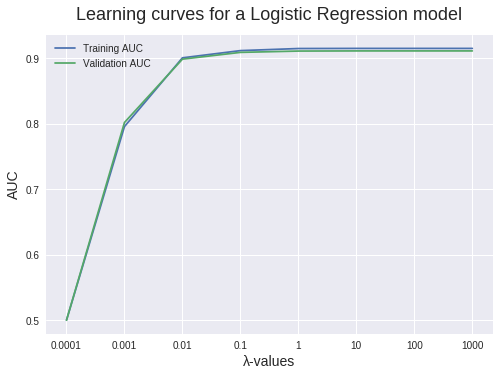

In [23]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [24]:
i = 10
LR = LogisticRegression(C=i , penalty="l1")
LR.fit(w2v_train, train_y)
# train data
y_prob_train = LR.predict_proba(w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 10 is 91.52%

CV AUC for λ = 10 is 91.14%

Test AUC for λ = 10 is 91.39%


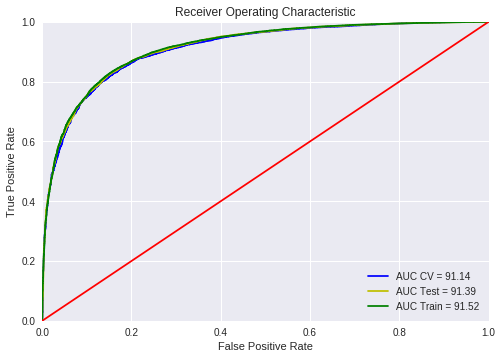

In [25]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.94


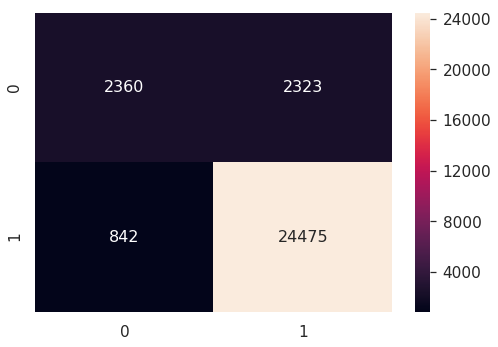

In [27]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [28]:
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  100
Number of non-zero weights :  100


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [29]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
C = [pow(10,j) for j in range(-4,4,1)]
w2v_train_auc = []
w2v_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l2")
    LR.fit(w2v_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 82.41%

CV AUC for λ = 0.0001 is 82.78%

Train AUC for λ = 0.001 is 89.60%

CV AUC for λ = 0.001 is 89.57%

Train AUC for λ = 0.01 is 90.71%

CV AUC for λ = 0.01 is 90.58%

Train AUC for λ = 0.1 is 91.25%

CV AUC for λ = 0.1 is 90.99%

Train AUC for λ = 1 is 91.49%

CV AUC for λ = 1 is 91.12%

Train AUC for λ = 10 is 91.52%

CV AUC for λ = 10 is 91.14%

Train AUC for λ = 100 is 91.52%

CV AUC for λ = 100 is 91.14%

Train AUC for λ = 1000 is 91.52%

CV AUC for λ = 1000 is 91.14%


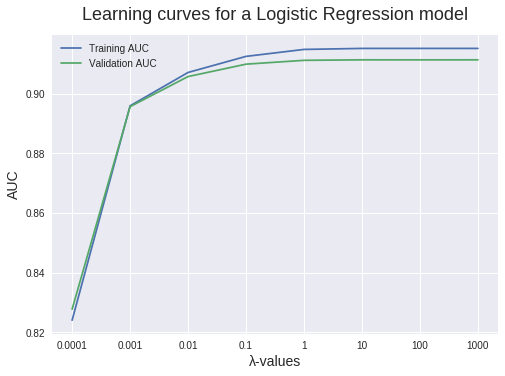

In [30]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [31]:
i = 10
LR = LogisticRegression(C=i , penalty="l2")
LR.fit(w2v_train, train_y)
# train data
y_prob_train = LR.predict_proba(w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 10 is 91.52%

CV AUC for λ = 10 is 91.14%

Test AUC for λ = 10 is 91.39%


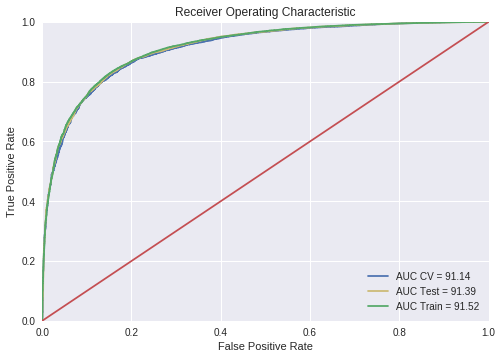

In [32]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.94


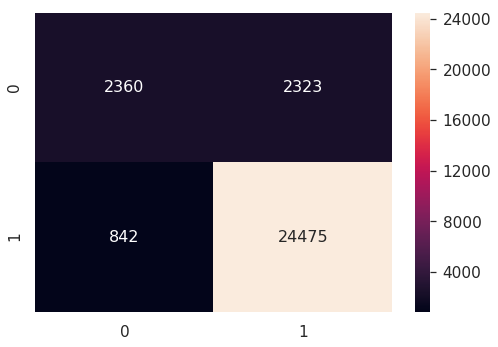

In [34]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [35]:

model = TfidfVectorizer()
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
final_tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
print("================CV Data===========")
final_tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])
print("================Test Data===========")
final_tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49000, 42951)
the number of unique words including both unigrams and bigrams  42951
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (21000, 42951)
the number of unique words including both unigrams and bigrams  42951
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 42951)
the number of unique words including both unigrams and bigrams  42951


In [37]:
######## Train #######
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [37:33<00:00, 21.75it/s]  


In [38]:
######## CV #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [15:30<00:00, 19.62it/s]


In [39]:
######## Train #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [22:19<00:00, 22.40it/s] 


In [40]:
# save the datasets as numpy array
tfidf_w2v_train = np.array(train_tfidf_sent_vectors)
tfidf_w2v_cv = np.array(cv_tfidf_sent_vectors)
tfidf_w2v_test = np.array(test_tfidf_sent_vectors)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [42]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
C = [pow(10,j) for j in range(-4,4,1)]
tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l1")
    LR.fit(tfidf_w2v_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(tfidf_w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(tfidf_w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 50.00%

CV AUC for λ = 0.0001 is 50.00%

Train AUC for λ = 0.001 is 75.20%

CV AUC for λ = 0.001 is 75.72%

Train AUC for λ = 0.01 is 87.58%

CV AUC for λ = 0.01 is 87.29%

Train AUC for λ = 0.1 is 88.99%

CV AUC for λ = 0.1 is 88.66%

Train AUC for λ = 1 is 89.25%

CV AUC for λ = 1 is 88.80%

Train AUC for λ = 10 is 89.26%

CV AUC for λ = 10 is 88.81%

Train AUC for λ = 100 is 89.26%

CV AUC for λ = 100 is 88.81%

Train AUC for λ = 1000 is 89.26%

CV AUC for λ = 1000 is 88.81%


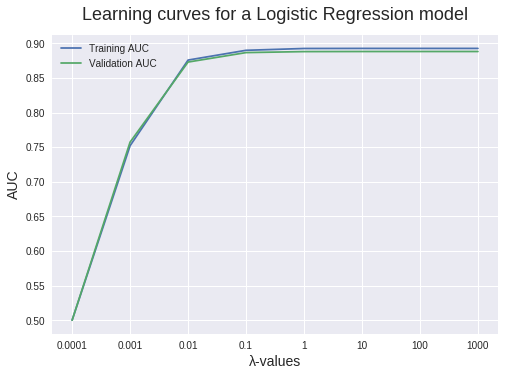

In [43]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [44]:
i = 100
LR = LogisticRegression(C=i , penalty="l1")
LR.fit(tfidf_w2v_train, train_y)
# train data
y_prob_train = LR.predict_proba(tfidf_w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(tfidf_w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(tfidf_w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 100 is 89.26%

CV AUC for λ = 100 is 88.81%

Test AUC for λ = 100 is 89.07%


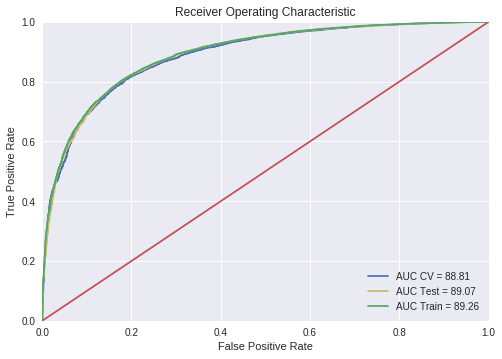

In [45]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.93


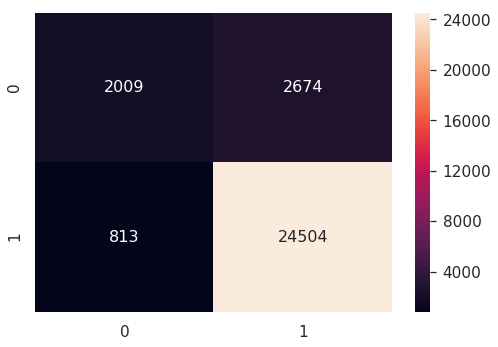

In [47]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [48]:
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  100
Number of non-zero weights :  100


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [49]:
# Please write all the code with proper documentation
C = [pow(10,j) for j in range(-4,4,1)]
tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l2")
    LR.fit(tfidf_w2v_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(tfidf_w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(tfidf_w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 79.52%

CV AUC for λ = 0.0001 is 79.49%

Train AUC for λ = 0.001 is 87.04%

CV AUC for λ = 0.001 is 86.92%

Train AUC for λ = 0.01 is 88.41%

CV AUC for λ = 0.01 is 88.24%

Train AUC for λ = 0.1 is 89.07%

CV AUC for λ = 0.1 is 88.74%

Train AUC for λ = 1 is 89.25%

CV AUC for λ = 1 is 88.82%

Train AUC for λ = 10 is 89.26%

CV AUC for λ = 10 is 88.82%

Train AUC for λ = 100 is 89.26%

CV AUC for λ = 100 is 88.81%

Train AUC for λ = 1000 is 89.26%

CV AUC for λ = 1000 is 88.81%


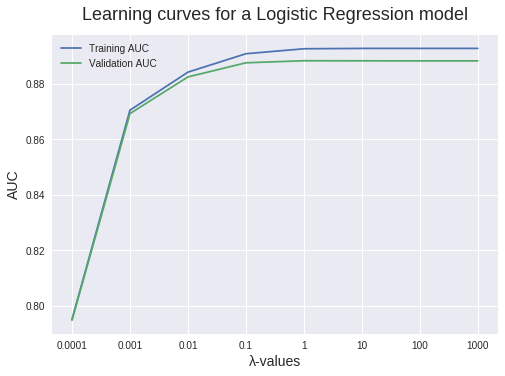

In [50]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [51]:
i = 1
LR = LogisticRegression(C=i , penalty="l2")
LR.fit(tfidf_w2v_train, train_y)
# train data
y_prob_train = LR.predict_proba(tfidf_w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(tfidf_w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(tfidf_w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 1 is 89.25%

CV AUC for λ = 1 is 88.82%

Test AUC for λ = 1 is 89.06%


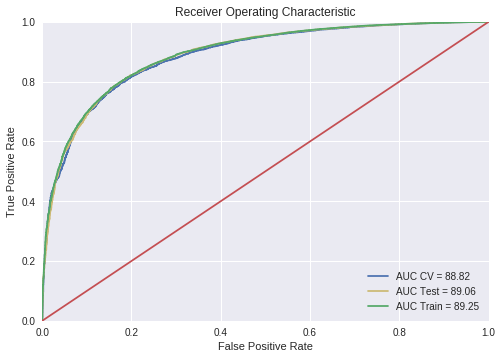

In [52]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [53]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.93


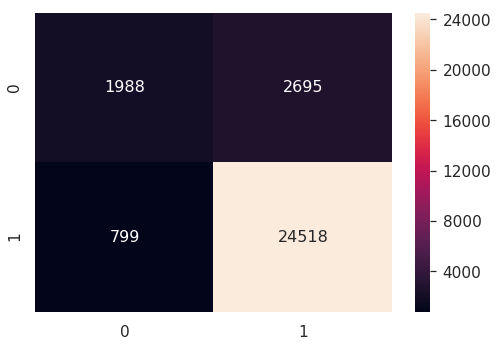

In [54]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [55]:
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  100
Number of non-zero weights :  100


### Feature engineeering

#### Taking length of reviews as another feature

In [57]:
# new featrue function text leangth
def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [58]:
# adding a new feature to dataframe as text_length
df['text_length'] = get_text_length(df["CleanedText"].values)

In [59]:
# take 100k sample data randomly
sample_data = df.sample(100000)
sample_data.shape

# sorted the data using time based
sorted_data = sample_data.sort_values('Time', axis=0, inplace=False)
sorted_data.shape

sorted_data['Score'].value_counts()

from sklearn.model_selection import train_test_split
text_length = np.array(sorted_data['text_length'])
X = np.array(sorted_data['CleanedText'])
y = np.array(sorted_data['Score'])
print(X.shape)
print(y.shape)
print(text_length.shape)

(100000,)
(100000,)
(100000,)


In [60]:
# Simple cross validation
# split the data sent into train and test
train , test, train_text, test_text , train_y , test_y = train_test_split(X,text_length, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train, cv , train_text, cv_text, train_y, cv_y = train_test_split(train, train_text, train_y, test_size=0.3, random_state=None)

print("train data = ", train.shape)
print("cros validation = ", cv.shape)
print("test data = ", test.shape)
print("train text = ",train_text.shape)
print("cv text = ",cv_text.shape)
print("test text = ", test_text.shape)

train data =  (49000,)
cros validation =  (21000,)
test data =  (30000,)
train text =  (49000,)
cv text =  (21000,)
test text =  (30000,)


In [61]:
#BoW
count_vect = CountVectorizer(min_df=15, ngram_range=(1,1)) #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.fit_transform(train)
bow_cv = count_vect.transform(cv)
bow_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv))
print("the shape of out text BOW vectorizer ",bow_cv.get_shape())
print("the number of unique words ", bow_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test))
print("the shape of out text BOW vectorizer ",bow_test.get_shape())
print("the number of unique words ", bow_test.get_shape()[1])

some feature names  ['abandoned', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'absurd']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 7030)
the number of unique words  7030
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 7030)
the number of unique words  7030
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 7030)
the number of unique words  7030


In [62]:
# adding a text_length feature to sparse matrix
from scipy.sparse import hstack
bow_train = hstack((bow_train,train_text[:,None]))
bow_cv = hstack((bow_cv,cv_text[:,None]))
bow_test = hstack((bow_test,test_text[:,None]))

In [63]:
#after adding new feature to sparce matrix
print("bow train shape = ", bow_train.shape)
print("bow cv shape = ", bow_cv.shape)
print("bow text shape = ",bow_test.shape)

bow train shape =  (49000, 7031)
bow cv shape =  (21000, 7031)
bow text shape =  (30000, 7031)


In [66]:
bow_train_auc = []
bow_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l2")
    LR.fit(bow_train, train_y)
    # train data
    y_prob_train = LR.predict_proba(bow_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(bow_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 65.86%

CV AUC for λ = 0.0001 is 65.76%

Train AUC for λ = 0.001 is 89.51%

CV AUC for λ = 0.001 is 88.98%

Train AUC for λ = 0.01 is 94.45%

CV AUC for λ = 0.01 is 93.24%

Train AUC for λ = 0.1 is 97.05%

CV AUC for λ = 0.1 is 94.13%

Train AUC for λ = 1 is 98.23%

CV AUC for λ = 1 is 93.53%

Train AUC for λ = 10 is 98.76%

CV AUC for λ = 10 is 92.68%

Train AUC for λ = 100 is 98.80%

CV AUC for λ = 100 is 92.58%

Train AUC for λ = 1000 is 98.77%

CV AUC for λ = 1000 is 92.64%


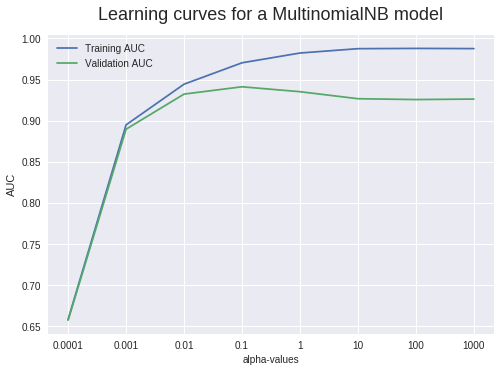

In [68]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC')
plt.xlabel('alpha-values', fontsize = 10)
plt.title('Learning curves for a MultinomialNB model', fontsize = 18, y = 1.03)
plt.legend()

In [69]:
i = 0.1
LR = LogisticRegression(C=i)
LR.fit(bow_train, train_y)
# train data
y_prob_train = LR.predict_proba(bow_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = LR.predict_proba(bow_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = LR.predict_proba(bow_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.1 is 97.05%

CV AUC for λ = 0.1 is 94.13%

Test AUC for λ = 0.1 is 94.08%


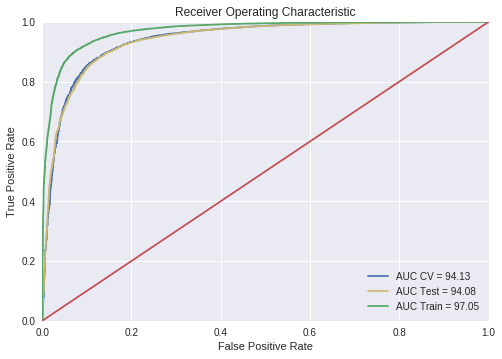

In [70]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.95


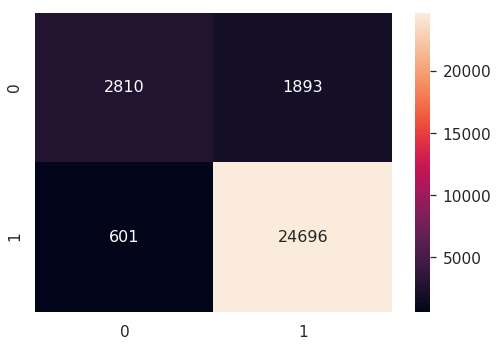

In [72]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [73]:
# number of non-zero weights
w = LR.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  7031
Number of non-zero weights :  7031


### Considering some features from review summary as well.

#### taking review summary as second model train bow model and take average averages of review text model and summary model

In [74]:
X_review = np.array(sorted_data['CleanedText'])
X_summary = np.array(sorted_data['Summary'])
y = np.array(sorted_data['Score'])
print(X_review.shape)
print(X_summary.shape)
print(y.shape)

(100000,)
(100000,)
(100000,)


In [75]:
# Simple cross validation
# split the data sent into train and test
train_review , test_review, train_summary, test_summary , train_y , test_y = train_test_split(X_review,X_summary, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train_review, cv_review, train_summary, cv_summary , train_y, cv_y = train_test_split(train_review, train_summary, train_y, test_size=0.3, random_state=None)

print("train review", train_review.shape)
print("cv review", cv_review.shape)
print("test review", test_review.shape)
print("train summary", train_summary.shape)
print("cv summary", cv_summary.shape)
print("test summary", test_summary.shape)

train review (49000,)
cv review (21000,)
test review (30000,)
train summary (49000,)
cv summary (21000,)
test summary (30000,)


In [76]:
# bow for summary
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=15, ngram_range=(1,2)) #in scikit-learn
count_vect.fit(train_summary)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train_summary = count_vect.fit_transform(train_summary)
bow_cv_summary = count_vect.transform(cv_summary)
bow_test_summary = count_vect.transform(test_summary)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train_summary))
print("the shape of out text BOW vectorizer ",bow_train_summary.get_shape())
print("the number of unique words ", bow_train_summary.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv_summary))
print("the shape of out text BOW vectorizer ",bow_cv_summary.get_shape())
print("the number of unique words ", bow_cv_summary.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test_summary))
print("the shape of out text BOW vectorizer ",bow_test_summary.get_shape())
print("the number of unique words ", bow_test_summary.get_shape()[1])

some feature names  ['10', '100', '11', '12', '16', '20', '24', '2nd', '40', '50']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 2292)
the number of unique words  2292
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 2292)
the number of unique words  2292
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 2292)
the number of unique words  2292


In [78]:
bow_train_auc = []
bow_cv_auc = []
for i in C:
    LR = LogisticRegression(C=i , penalty="l2")
    LR.fit(bow_train_summary, train_y)
    # train data
    y_prob_train = LR.predict_proba(bow_train_summary)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = LR.predict_proba(bow_cv_summary)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 77.51%

CV AUC for λ = 0.0001 is 77.34%

Train AUC for λ = 0.001 is 86.92%

CV AUC for λ = 0.001 is 86.40%

Train AUC for λ = 0.01 is 90.75%

CV AUC for λ = 0.01 is 90.05%

Train AUC for λ = 0.1 is 93.78%

CV AUC for λ = 0.1 is 92.62%

Train AUC for λ = 1 is 95.31%

CV AUC for λ = 1 is 93.34%

Train AUC for λ = 10 is 95.77%

CV AUC for λ = 10 is 92.94%

Train AUC for λ = 100 is 95.86%

CV AUC for λ = 100 is 92.44%

Train AUC for λ = 1000 is 95.87%

CV AUC for λ = 1000 is 92.04%


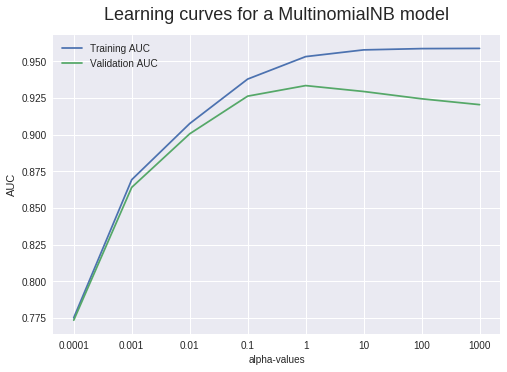

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC')
plt.xlabel('alpha-values', fontsize = 10)
plt.title('Learning curves for a MultinomialNB model', fontsize = 18, y = 1.03)
plt.legend()

In [83]:
# summary text
i = 1
LR = LogisticRegression(C=i)
LR.fit(bow_train_summary, train_y)
# Test
y_prob_test_summary = LR.predict_proba(bow_test_summary)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test_summary)
y_pred_test = np.where(y_prob_test_summary > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test_summary)
print('\nTest AUC for alpha = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))


Test AUC for alpha = 1 is 93.14%


In [85]:
# bow for review
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=15, ngram_range=(1,2)) #in scikit-learn
count_vect.fit(train_review)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train_review = count_vect.fit_transform(train_review)
bow_cv_review = count_vect.transform(cv_review)
bow_test_review = count_vect.transform(test_review)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train_review))
print("the shape of out text BOW vectorizer ",bow_train_review.get_shape())
print("the number of unique words ", bow_train_review.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv_review))
print("the shape of out text BOW vectorizer ",bow_cv_review.get_shape())
print("the number of unique words ", bow_cv_review.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test_review))
print("the shape of out text BOW vectorizer ",bow_test_review.get_shape())
print("the number of unique words ", bow_test_review.get_shape()[1])

some feature names  ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 18484)
the number of unique words  18484
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 18484)
the number of unique words  18484
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 18484)
the number of unique words  18484


In [87]:
# review text
i = 1
LR = LogisticRegression(C=i)
LR.fit(bow_train_review, train_y)
# Test
y_prob_test_review = LR.predict_proba(bow_test_review)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test_review)
y_pred_test = np.where(y_prob_test_review > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test_review)
print('\nTest AUC for alpha = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))


Test AUC for alpha = 1 is 94.73%


In [88]:
# adding both summary and review test probabilitys and average
new_proba = (y_prob_test_review + y_prob_test_summary) / 2

In [89]:
fprts, tprts, throsholdts = roc_curve(test_y, new_proba)
y_pred_test = np.where(new_proba > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , new_proba)
print('\nTest AUC for alpha = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))


Test AUC for alpha = 1 is 97.46%


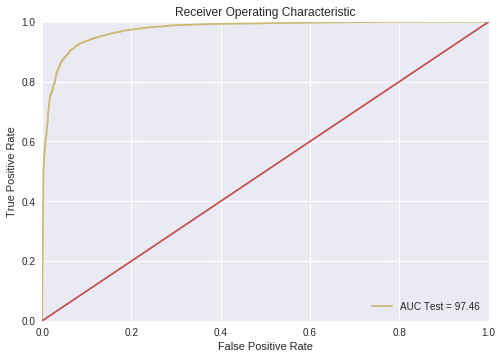

In [92]:
import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.97


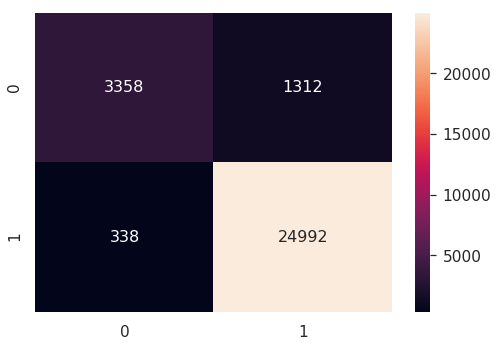

In [94]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

***Observation :*** : adding two models we get better results. we see the 97.46% AUC and F1 score is 0.97

# [6] Conclusions

In [95]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer" , "Regularization","Hyper parameter \u03BB", "AUC", "F1 Score"])

x.add_row(["BOW", "L2" ,0.1, "95.19%", 0.96])
x.add_row(["BOW","L1" , 1,"95.06%", 0.96])
x.add_row(["TFIDF", "L1" ,1, "95.36%", 0.96])
x.add_row(["TFIDF","L2" , 1,"95.89%", 0.96])
x.add_row(["AVG-W2V", "L1" ,10, "91.39%", 0.94])
x.add_row(["AVG-W2V","L2" , 1,"91.39%", 0.94])
x.add_row(["TFIDF-W2V", "L1" ,100, "89.07%", 0.93])
x.add_row(["TFIDF-W2V","L2" , 1,"89.06%", 0.93])

print(x.get_string(title="LR Model"))

+------------+----------------+-------------------+--------+----------+
| Vectorizer | Regularization | Hyper parameter λ |  AUC   | F1 Score |
+------------+----------------+-------------------+--------+----------+
|    BOW     |       L2       |        0.1        | 95.19% |   0.96   |
|    BOW     |       L1       |         1         | 95.06% |   0.96   |
|   TFIDF    |       L1       |         1         | 95.36% |   0.96   |
|   TFIDF    |       L2       |         1         | 95.89% |   0.96   |
|  AVG-W2V   |       L1       |         10        | 91.39% |   0.94   |
|  AVG-W2V   |       L2       |         1         | 91.39% |   0.94   |
| TFIDF-W2V  |       L1       |        100        | 89.07% |   0.93   |
| TFIDF-W2V  |       L2       |         1         | 89.06% |   0.93   |
+------------+----------------+-------------------+--------+----------+


### Feature engineering

In [96]:
x = PrettyTable(["Feature" , "Vectorizer" , "Regularization","Hyper parameter \u03BB", "AUC", "F1 Score"])

x.add_row(["Test length", "BOW", "L2", 0.1, "94.08%", 0.95])
x.add_row(["Summary + Review", "BOW", "L2",1 , "97.46%", 0.97])

print(x.get_string(title="MNB Model"))

+------------------+------------+----------------+-------------------+--------+----------+
|     Feature      | Vectorizer | Regularization | Hyper parameter λ |  AUC   | F1 Score |
+------------------+------------+----------------+-------------------+--------+----------+
|   Test length    |    BOW     |       L2       |        0.1        | 94.08% |   0.95   |
| Summary + Review |    BOW     |       L2       |         1         | 97.46% |   0.97   |
+------------------+------------+----------------+-------------------+--------+----------+
